<a href="https://colab.research.google.com/github/skipsleep/Online-Compiler-Web/blob/master/Generation_Scheduling_in_Power_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
tic = time.process_time()
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
data = np.loadtxt('/content/gdrive/MyDrive/data.txt', dtype=float)
print(data)

'''
    N = total number of units
    pu[i] = upper power generation limit of ith unit
    pl[i] = lower power generation limit of ith unit
    a[i],b[i],c[i] are coefficients of production cost equation cost = a*x^2 + b^x + c
'''
# Extracting data
a = data[:, 0]
b = data[:, 1]
c = data[:, 2]
pu = data[:, 3]
pl = data[:, 4]
N = len(a)

# Converting upper and lower limits of unit operation into integer datatype
pu = pu.astype(int)
pl = pl.astype(int)

# Validating input
print(a.shape, b.shape, c.shape)
print(pl)
print(pu)






Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[[5.00000e-03 5.62700e+00 2.61186e+02 2.25000e+02 7.00000e+01]
 [6.00000e-03 5.50600e+00 2.64634e+02 2.40000e+02 7.00000e+01]
 [4.00000e-03 6.38300e+00 1.90502e+02 2.85000e+02 1.10000e+02]
 [5.00000e-03 6.29500e+00 2.30154e+02 2.82000e+02 1.10000e+02]
 [7.00000e-03 6.65400e+00 1.12922e+02 1.14000e+02 3.00000e+01]
 [1.20000e-02 6.36200e+00 1.43092e+02 9.10000e+01 3.00000e+01]
 [1.20000e-02 6.51500e+00 1.35334e+02 1.05000e+02 4.00000e+01]
 [1.60000e-02 6.26800e+00 1.54298e+02 1.04000e+02 3.00000e+01]
 [2.20000e-02 7.75000e+00 9.31000e+01 7.00000e+01 3.50000e+01]
 [2.40000e-02 8.06200e+00 8.82000e+01 6.30000e+01 3.50000e+01]
 [3.00000e-02 7.66700e+00 9.99600e+01 7.70000e+01 3.50000e+01]
 [2.90000e-02 7.71600e+00 1.05840e+02 6.60000e+01 3.50000e+01]
 [3.00000e-02 8.31700e+00 9.11400e+01 7.70000e+01 3.50000e+01]
 [1.00000e-02 1.17520e+01 1.00659e+02 1.18000e+02 

In [2]:
'''
    p_max = maximum generation possible (all units operating on upper limits pu)
    p_min = minimum generation possible (the unit with minimum lower limit operating)
'''
p_max = int(np.sum(pu))
p_min = int(np.min(pl))

print(p_min, p_max)


# Function to calculate cost in ($/hr) for ith unit
def cost(i, x):
    """
    :param i: ith unit
    :param x: generation requirement x
    :return: cost of generation x from ith unit
    """
    if x == 0:
        return 0
    if pu[i] >= x >= pl[i]:
        return a[i] * x * x + b[i] * x + c[i]
    return np.inf


# Testing cost function
print(cost(0, 10))

20 2035
inf


In [3]:
'''
    unit_cost[i][x]: cost of generation x from ith unit
'''
# calculating cost($/hr) for each unit and storing it in unit_cost
unit_cost = list()
for i in range(0, N):
    unit_i = list()
    for j in range(0, p_max + 1):
        unit_i.append(cost(i, j))
    unit_cost.append(unit_i)

# Converting list datatype to numpy array for numpy computations
unit_cost = np.array(unit_cost)

print(unit_cost.shape)

print(unit_cost[:, p_min:])

(15, 2036)
[[    inf     inf     inf ...     inf     inf     inf]
 [    inf     inf     inf ...     inf     inf     inf]
 [    inf     inf     inf ...     inf     inf     inf]
 ...
 [    inf     inf     inf ...     inf     inf     inf]
 [339.699 351.861 364.043 ...     inf     inf     inf]
 [345.25  357.612 369.992 ...     inf     inf     inf]]


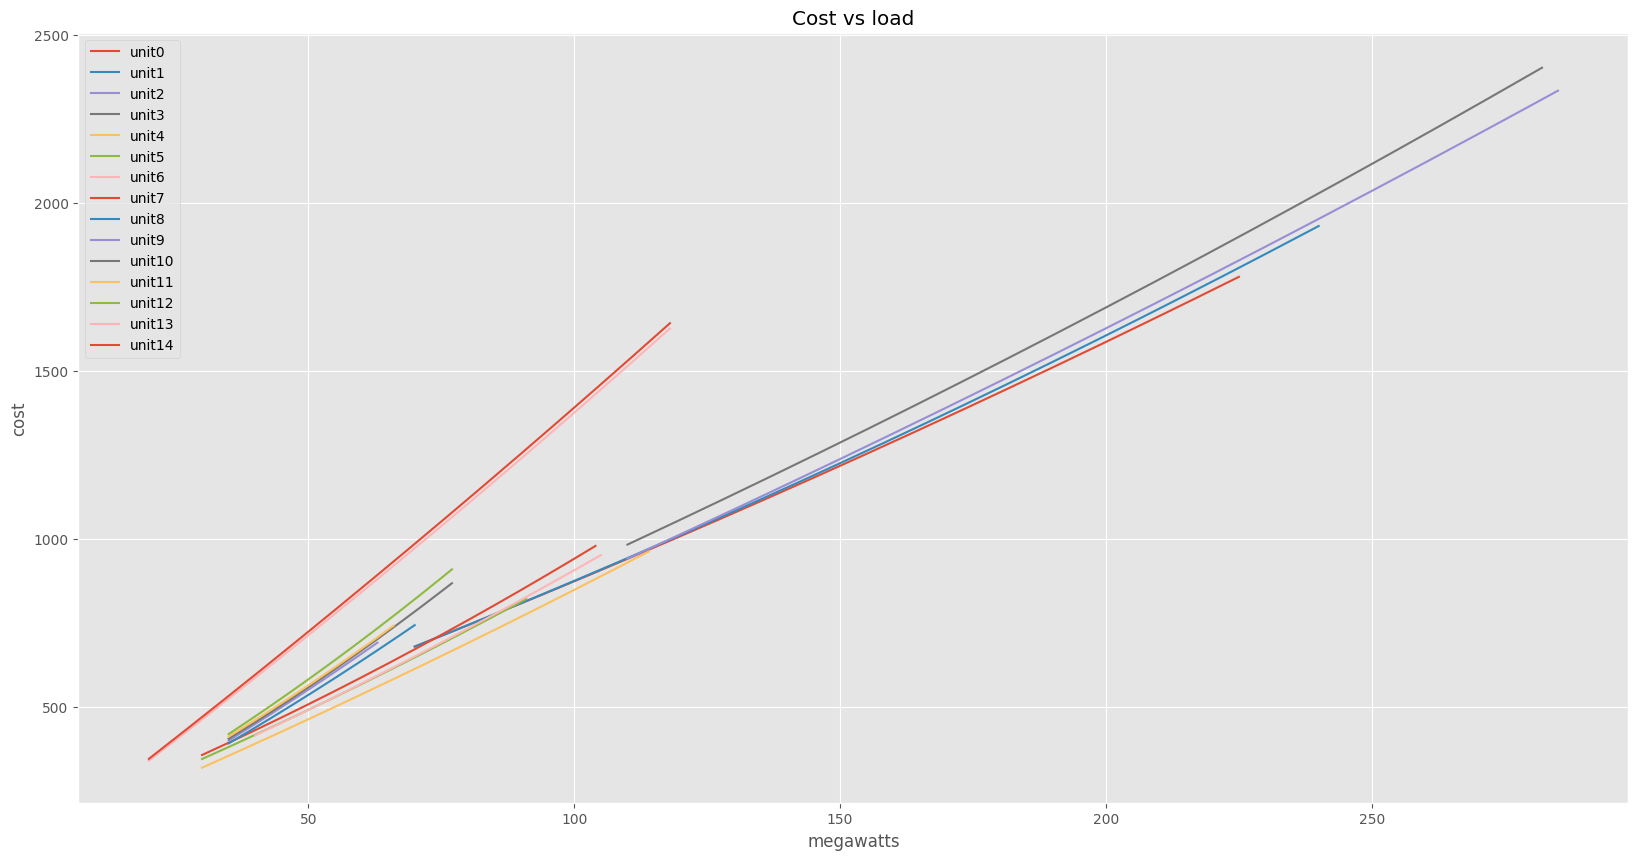

In [4]:
def plot_units():
    """

    :return: plot of cost vs load for all units
    """
    # fixing the size of figure
    plt.figure(figsize=(20, 10))

    plt.style.use('ggplot')

    # plotting the line points
    for i in range(0, N):
        plt.plot(np.arange(p_min, p_max + 1), unit_cost[i][p_min:], label="unit" + str(i))

    # labelling the axes
    plt.xlabel('megawatts')
    plt.ylabel('cost')

    # giving a title to my graph
    plt.title('Cost vs load')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()


# plotting units cost vs load
plot_units()

In [5]:
 """
    Setting up memory blocks for Dynamic programming
    f: 2D array of size (N+1,max_load+1) for storing minimum cost.
    uc: 3D array of size (N+1, max_load+1, N+1) for storing unit
        commitment along with power generated by each unit for
        a generation requirement.

"""
# f[i][j]: min cost for generation j by first i machines
f = np.full((N + 1, int(p_max) + 1), np.inf, dtype=float)

'''
    note: unit_cost[i][j] has zero based indexing but f has one based indexing.
    => f[1,:] = unit_cost[0,:]
'''
# f[1][j] = cost(0,j), since it is the only unit working
f[1, :] = unit_cost[0, :]

# f[i][0] = 0 since all units are off
f[:, 0] = 0

'''
    We define unit commitment 3D array for memoization.
    uc[i][x][j]: no of units produced by jth unit when first i units are used
                 to produce x MW of power
                 OR we can say,
                 no of units produced by the jth unit in f[i][x]
'''
# unit commitment declaration
uc = np.zeros((N + 1, p_max + 1, N + 1))

# initialising unit commitment 3D array for producing x MW using 1st unit.
for x in range(pl[0], pu[0] + 1):
    uc[1][x][1] = x
print(uc.shape, f.shape)

(16, 2036, 16) (16, 2036)


In [10]:
'''
    Dynamic Programming loop
'''
# Traversing all the units from 1 to N
for i in range(1, N + 1):

    # Traversing the range of generation requirement
    for x in range(p_min, p_max + 1):
        if f[i][x] > f[i - 1][x]:
            f[i][x] = f[i - 1][x]
            uc[i][x] = uc[i - 1][x]

        # Determining best value ith unit should take for min cost.
        for y in range(0, x + 1):
          # since cost is zero based index and f is 1 based index
            f_i_x = cost(i - 1, y) + f[i - 1][x - y]
            if f_i_x < f[i][x]:
                f[i][x] = f_i_x
                uc[i][x] = uc[i - 1][x - y]
                uc[i][x][i] = uc[i][x][i] + y

# Validating the total generation x with total unit commitment
print(uc[N][p_max])

[  0. 225. 240. 285. 282. 114.  91. 105. 104.  70.  63.  77.  66.  77.
 118. 118.]


<Figure size 1000x600 with 0 Axes>

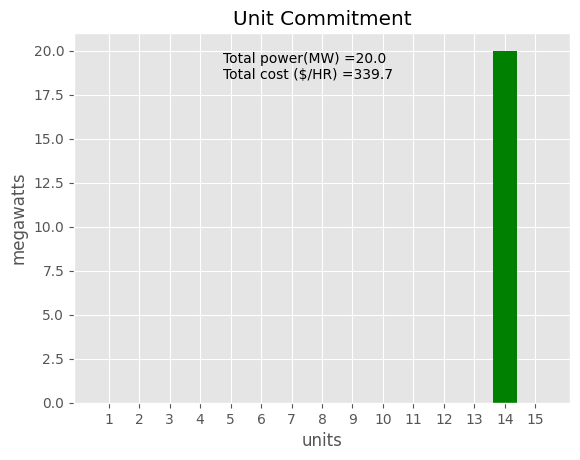

<Figure size 1000x600 with 0 Axes>

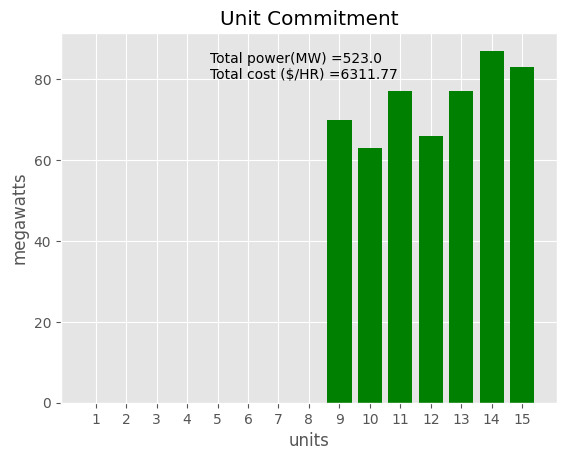

<Figure size 1000x600 with 0 Axes>

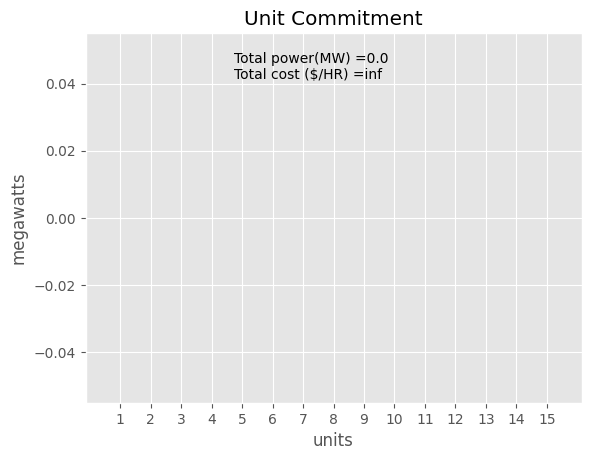

<Figure size 1000x600 with 0 Axes>

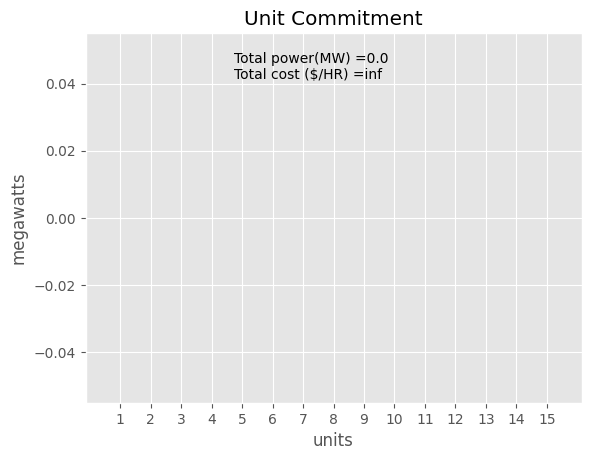

<Figure size 1000x600 with 0 Axes>

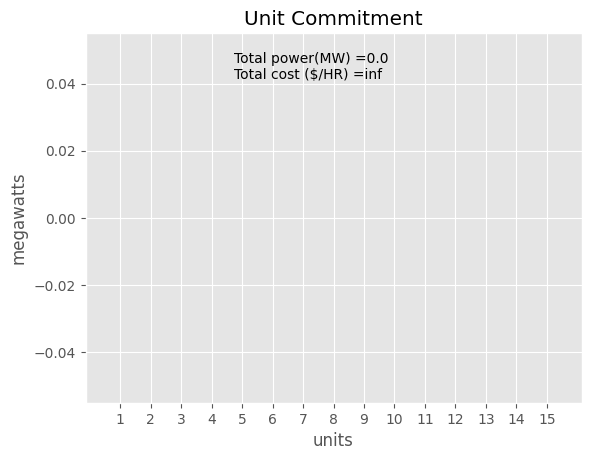

In [7]:
def plot_uc(n):
    """
    :param n: generation requirement x
    :return: plot of unit commitment
    """
    # fixing the size of figure
    plt.figure(figsize=(10, 6))

    # plotting the line points
    fig, ax = plt.subplots()
    p1 = ax.bar(np.arange(1, N + 1), uc[N][n][1:N + 1],color='green')

    # creating text to display
    textstr = ('Total power(MW) =' + str(np.sum(uc[N][n][1:N + 1])) + '\n'
               + 'Total cost ($/HR) =' + str(round(f[N][n], 2)))

    # labelling the axes
    plt.xlabel('units')
    plt.ylabel('megawatts')
    ax.set_xticks(np.arange(1, N + 1))
    #ax.bar_label(p1)
    ax.text(0.30, 0.95, textstr, transform=ax.transAxes,
            verticalalignment='top', ha='left')

    # giving a title to my graph
    plt.title('Unit Commitment')

    # function to show the plot
    with plt.style.context(('dark_background')):
        plt.show()

# plotting unit commitment
for i in range(p_min, p_max + 1, (p_max - p_min) // 4):
    plot_uc(i)

In [8]:
"""
    Comparing economic dispatch with single unit generations
"""

# Calculating cost for each unit i without pl and pu limits
unit_cost_boundless = list()

for i in range(0, N):
    unit_i_cost = list()
    for j in range(0, p_max + 1):
        unit_i_cost.append(a[i] * j * j + b[i] * j + c[i])
    unit_cost_boundless.append(unit_i_cost)

unit_cost_boundless = np.array(unit_cost_boundless)
print(unit_cost_boundless.shape)

(15, 2036)


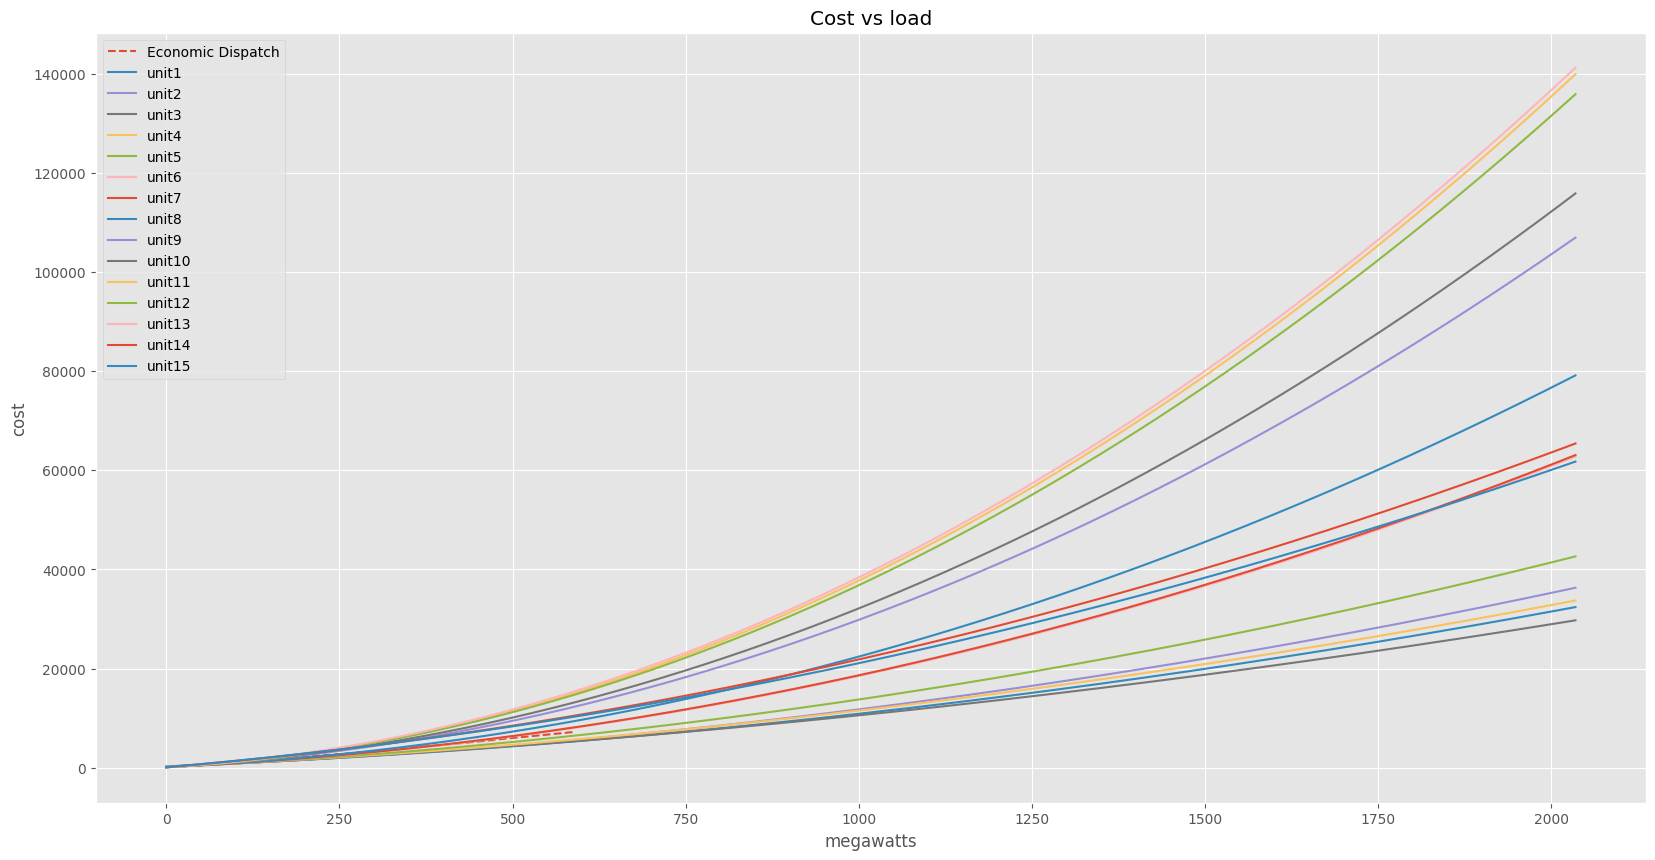

Time =  34.523401539000005


In [9]:
def plot_ed():
    """

    :return: comparison plot of cost vs load for economic dispatch
    """
    # fixing the size of figure
    plt.figure(figsize=(20,10))

    # plotting the line points
    plt.plot(np.arange(p_max + 1), f[N], label="Economic Dispatch",linestyle='dashed')
    for i in range(0, N):
        plt.plot(np.arange(int(p_max) + 1), unit_cost_boundless[i], label="unit" + str(i+1))

    # labelling the axes
    plt.xlabel('megawatts')
    plt.ylabel('cost')

    # giving a title to my graph
    plt.title('Cost vs load')

    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()


# Plotting Economic dispatch
plot_ed()
toc = time.process_time()

print("Time = ", toc - tic)